In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ravirajsinh45/crop-and-weed-detection-data-with-bounding-boxes

 99% 78.0M/79.2M [00:02<00:00, 38.5MB/s]
100% 79.2M/79.2M [00:02<00:00, 29.8MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/crop-and-weed-detection-data-with-bounding-boxes.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil

In [6]:
info=pd.DataFrame(columns = ["Name","Class","X", "Y", "Width", "Height"])

In [7]:
info

,Name,Class,X,Y,Width,Height


In [8]:
name = []
clas = []
x = []
y = []
w = []
h = []
path = "/content/agri_data/data/"
for file in os.listdir(path):
  if file.split(".")[-1] == "txt":
    with open(path + file, "r") as f :
      for line in f.readlines():
        data = line.split(" ")
        name.append(file.split(".")[0])
        clas.append(data[0])
        x.append(data[1])
        y.append(data[2])
        w.append(data[3])
        h.append(data[4])

In [9]:
len(name), len(clas), len(x), len(y),len(w), len(h)

(2072, 2072, 2072, 2072, 2072, 2072)

In [10]:
info["Name"] = pd.Series(name)
info["Class"] = pd.Series(clas)
info["X"] = pd.to_numeric(pd.Series(x))
info["Y"] = pd.to_numeric(pd.Series(y))
info["Width"] = pd.to_numeric(pd.Series(w))
info["Height"] = pd.to_numeric(pd.Series(h))

In [11]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    2072 non-null   object 
 1   Class   2072 non-null   object 
 2   X       2072 non-null   float64
 3   Y       2072 non-null   float64
 4   Width   2072 non-null   float64
 5   Height  2072 non-null   float64
dtypes: float64(4), object(2)
memory usage: 97.2+ KB


In [12]:
!mkdir Cropped_data
!mkdir Cropped_data/Crop
!mkdir Cropped_data/Weed

In [13]:
from PIL import Image

In [14]:
def crop_pic(image_name, x, y, w, h):
  source_path = "/content/agri_data/data/"
  image = plt.imread(f"{source_path}{image_name}.jpeg")
  #taking the shape
  W,H = image.shape[1],image.shape[0]
  #normalizing
  X = x*W
  Y = y*H
  width = w*W
  height = h*H

  x1 = int( X - (int(width) // 2))
  y1 = int( Y - (int(height) // 2))
  x2 = int( X + (int(width) // 2))
  y2 = int( Y + (int(height) // 2))
  # print(x1,x2, y1, y2)

  # Crop the image using the calculated coordinates
  cropped_image = image[y1:y2,  x1:x2]
  # print(W,H,x,y)
  return cropped_image
  #-------------------------------------------------------------------------
#Cropping the image and adding to its corresponding folder.
for index in range(info.shape[0]):
  cropped_pic = crop_pic( info.iloc[index,0], info.iloc[index,2], info.iloc[index,3], info.iloc[index,4],info.iloc[index,5] )
  reduced_img = Image.fromarray(cropped_pic)
  reduced_img = reduced_img.resize((256,256))
  # print(info.iloc[index,1],info.iloc[index,0])
  if info.iloc[index,1] == '0':
    reduced_img.save(f"/content/Cropped_data/Crop/{index}.jpeg")
  else:
    reduced_img.save(f"/content/Cropped_data/Weed/{index}.jpeg")

In [15]:
len(os.listdir("/content/Cropped_data/Crop"))+len(os.listdir("/content/Cropped_data/Weed"))

2072

In [16]:
info.shape

(2072, 6)

In [17]:
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential

In [18]:
dataset = image_dataset_from_directory("/content/Cropped_data/",image_size = (256,256))

Found 2072 files belonging to 2 classes.


In [19]:
dataset.class_names

['Crop', 'Weed']

In [20]:
# Normalization
def process(image,label):
    image = tf.cast (image/255.0 ,tf.float32)
    return image,label
dataset = dataset.map(process)

In [21]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 252, 252, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 64)      3

In [23]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
history = model.fit(dataset, epochs=10, batch_size=32)

Epoch 1/10
65/65 [==============================] - 39s 255ms/step - loss: 0.3844 - accuracy: 0.8378
Epoch 2/10
65/65 [==============================] - 13s 191ms/step - loss: 0.2955 - accuracy: 0.8977
Epoch 3/10
65/65 [==============================] - 14s 194ms/step - loss: 0.2502 - accuracy: 0.9170
Epoch 4/10
65/65 [==============================] - 13s 193ms/step - loss: 0.2478 - accuracy: 0.9180
Epoch 5/10
65/65 [==============================] - 13s 195ms/step - loss: 0.2010 - accuracy: 0.9377
Epoch 6/10
65/65 [==============================] - 13s 198ms/step - loss: 0.2072 - accuracy: 0.9373
Epoch 7/10
65/65 [==============================] - 13s 199ms/step - loss: 0.1931 - accuracy: 0.9358
Epoch 8/10
65/65 [==============================] - 13s 201ms/step - loss: 0.1743 - accuracy: 0.9411
Epoch 9/10
65/65 [==============================] - 13s 204ms/step - loss: 0.1755 - accuracy: 0.9431
Epoch 10/10
65/65 [==============================] - 14s 206ms/step - loss: 0.1568 - accura

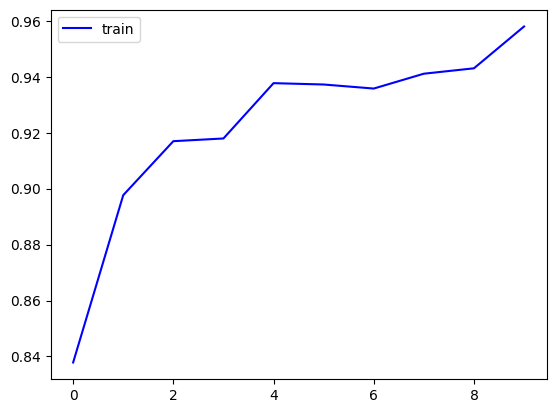

In [25]:
plt.plot(history.history['accuracy'],color='blue',label='train')
plt.legend()
plt.show()

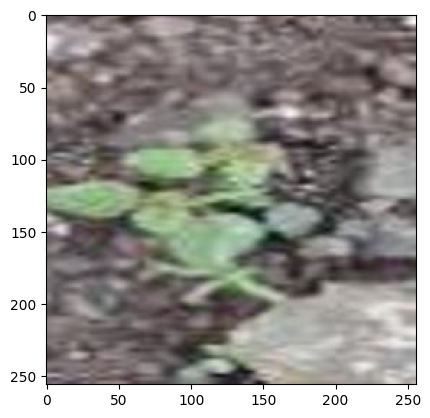

1/1 [==============================] - 0s 32ms/step
Weed


In [32]:
test_image = plt.imread("/content/Cropped_data/Weed/1029.jpeg")
plt.imshow(test_image)
plt.show()
test_image = process(test_image,0)[0]
test_image = np.array(test_image).reshape((1,256,256,3))
# test_image = test_image.reshape((1,256,256,3))
if model.predict([test_image])[0]:
  print("Weed")
else:
  print("Crop")

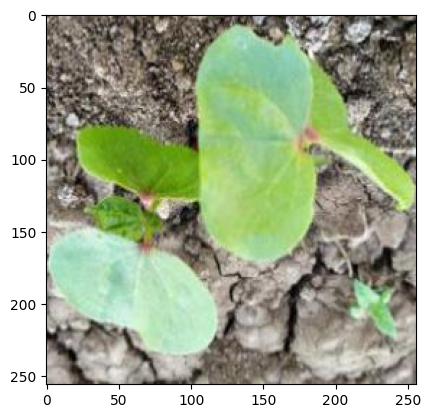

1/1 [==============================] - 0s 26ms/step
Crop


In [30]:
test_image = plt.imread("/content/Cropped_data/Crop/1034.jpeg")
plt.imshow(test_image)
plt.show()
test_image = process(test_image,0)[0]
test_image = np.array(test_image).reshape((1,256,256,3))
# model.predict([test_image])

if model.predict([test_image])[0]>0.50:
  print("Weed")
else:
  print("Crop")